# Tutorial 2: SpaCon for layer6 CT neuron subtype classification

This tutorial demonstrates how to use SpaCon for cell subtype classification. Here, we use corticothalamic (CT) neurons from Layer 6 of the mouse cortex as an example.

The spatial transcriptomics data used in this tutorial is MERFISH data from the study published in *Nature*: [Molecularly defined and spatially resolved cell atlas of the whole mouse brain](https://www.nature.com/articles/s41586-023-06808-9). The structural connectivity data is sourced from the [Allen Mouse Brain Connectivity Atlas](https://connectivity.brain-map.org/).

We have co-registered both datasets to the same resolution. The processed data for this tutorial can be downloaded from this [Google Drive link](https://www.google.com/search?q=https://drive.google.com/drive/folders/1lQQQVjXt8lvciuKq_Jkp4LGsR_EQXFAi%3Fusp%3Dsharing).

In [1]:
import spacon
from spacon.utils import build_spatial_graph, build_connection_graph, neighbor_sample, model_train, model_eval, clustering, plot_all_results

from spacon.model import SpaCon

import datetime
import os
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt

import torch
import numpy as np
import random
import alphashape
import seaborn as sns
from scipy.interpolate import splprep, splev
from matplotlib.colors import to_rgba
from matplotlib.patches import Polygon

import warnings
warnings.filterwarnings("ignore")

mus = 'mouse_3'
if mus == 'mouse_1':  # coronal
    plot_x, plot_y = 'z', 'y'
    figsize = (5,5)
elif mus == 'mouse_3':   # sagittal
    plot_x, plot_y = 'x', 'y'
    figsize = (11,5)

ctx_regions = ['ACAd', 'ACAv', 'AId', 'AIp', 'AIv', 'AUDd', 'AUDp', 'AUDpo', 'AUDv', 'ECT', 'FRP', 'GU', 'ILA', 'MOp', 'MOs', 'ORBl', 'ORBm', 'ORBvl', 'PERI', 'PL', 'RSPagl', 'RSPd', 'RSPv',
               'SSp-bfd', 'SSp-ll', 'SSp-m', 'SSp-n', 'SSp-tr', 'SSp-ul', 'SSp-un', 'SSs', 'TEa', 'VISC', 'VISa', 'VISal', 'VISam', 'VISl', 'VISli', 'VISp', 'VISpl', 'VISpm', 'VISpor', 'VISrl']

def set_seed(seed: int):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

/mnt/Data16Tc/home/haichao/anaconda3/envs/SpaCon_clone/lib/python3.8/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


**Data preprocessing**

**Load spatial transcriptomics data**

If there are too many genes (for example, more than 5,000), we recommend first screening for highly variable genes using the following method:

```
n_top_genes = 3000
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=n_top_genes)
adata = adata[:, adata.var.highly_variable]
```

In [2]:
# adata = sc.read_h5ad(f'./data/{mus}/adata_030_L6_CT_CTX_Glut_and_th.h5ad')
adata = sc.read_h5ad('/mnt/Data16Tc/home/haichao/code/SpaCon_github/data_public/Experiment 2/layer6CT_and_th.h5ad')
print('raw adata shape:', adata.shape)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata

raw adata shape: (7932, 1122)


AnnData object with n_obs × n_vars = 7932 × 1122
    obs: 'x', 'y', 'z', 'section', 'NT_index', 'Cells_id'
    uns: 'log1p'

**Build spatial graph**

The `build_spatial_graph` function constructs a spatial graph using the three-dimensional spatial coordinates of the spatial transcriptome. The main parameters include:

- `adata`: Spatial transcriptomics data must include the three-dimensional coordinates for each spot (i.e., the slice number and the two-dimensional coordinates within that slice).
- `section_order`: A slice order list where the sequence represents the original arrangement of each slice within the brain. While the slices can be oriented differently, their relative order must be strictly maintained.
- `rad_cutoff`: Neighborhood radius, each spot will have edges added to all other spots within its neighborhood radius.
- `rad_cutoff_Zaxis`: Inter-slice neighborhood radius, each spot will have edges added to spots in adjacent slices that are within this radius.
- `sec_x`: The column name in `adata.obs` that stores the x-coordinate of each spot within its slice.
- `sec_y`: The column name in `adata.obs` that stores the y-coordinate of each spot within its slice.
- `key_section`: Column name in `adata.obs` that stores the slice number (where different numbers indicate different slices).

In [3]:
# build the section list
section_order = np.unique(adata.obs['section']).tolist()
# calculate the spatial graph for the adata
ST_graph_data, st_adj = build_spatial_graph(adata=adata,  rad_cutoff=0.7, rad_cutoff_Zaxis=1,
                                            sec_x='x', sec_y='y', key_section='section',
                                            section_order=section_order)
ST_graph_data

100%|██████████| 10/10 [00:02<00:00,  4.38it/s]


Data(x=[7932, 1122], edge_index=[2, 45616])

**Load connectivity data and build connection graph**

The `build_connection_graph` function uses connection information to construct a three-dimensional connection graph. The main parameters include:

- `nt_adj`: An n x n two-dimensional matrix, where n is the number of spots in the spatial transcriptomics data, representing the connection strength between spots.
- `threshold`: Filtering threshold, connection strengths below this value will be set to zero.

In [4]:
# with open(f'/mnt/Data18Td/Data/haichao/mouse_connect_data/NT/zxw/{mus}/PyG_Data_eps0.001_0.027_030_L6_CT_CTX_Glut_and_th_only_ctx2th_conn.pkl', 'rb') as f:

#     NT_graph_data = pickle.load(f)


nt_adj = np.load('/mnt/Data16Tc/home/haichao/code/SpaCon_github/data_public/Experiment 2/layer6CT_and_th_connection.npy')
NT_graph_data = build_connection_graph(adata, nt_adj, threshold=0.001)
NT_graph_data

Data(x=[7932, 1122], edge_index=[2, 5445454])

**Neighbor-based subgraph sampling**

The `neighbor_sample` function performs subgraph sampling from the input spatial graph and connection graph. Its main parameters include:

- `batch_size`: The batch size for model training.
- `train_num_neighbors`: The number of neighbors to sample for each node in each iteration. This parameter is used by the data loader during the model training process.
- `eval_num_neighbors`: The number of neighbors to sample for each node in each iteration. This parameter is used by the data loader during the model evaluation process. If an entry is set to -1, all neighbors will be included.(default:`[-1]`)

The function returns three data loaders: `train_loader`, `evaluate_loader_con`, and `evaluate_loader_spa`. The `train_loader` is used during the **model training process**. Meanwhile, `evaluate_loader_con` and `evaluate_loader_spa` are used for **model evaluation** on the **connection graph** and **spatial graph**, respectively.

In [5]:
train_loader, evaluate_loader_con, evaluate_loader_spa = neighbor_sample(NT_graph_data, ST_graph_data, batch_size=64, train_num_neighbors=[20, 10, 10], num_workers=4)

**Model training**

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# hyper-parameters
num_epoch = 10
lr = 0.0001
weight_decay = 1e-4
hidden_dims = [adata.X.shape[1]] + [256, 128, 64]    
# model
# fusion_method indicates the feature fusion method of the middle layer, you can choose 'add' or 'concat'
model = SpaCon(hidden_dims=hidden_dims, fusion_method='concat').to(device)
# if model_save_path=None, the model will not be saved
results_save_path = f"./results_celltype/{mus}/{str(datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S'))}/"
os.makedirs(results_save_path, exist_ok=True)

model = model_train(num_epoch, lr, weight_decay, model, train_loader, st_adj, model_save_path=results_save_path, device=device)

epoch:1|10


100%|██████████| 124/124 [00:04<00:00, 29.13it/s]


epoch:2|10


100%|██████████| 124/124 [00:03<00:00, 32.58it/s]


epoch:3|10


100%|██████████| 124/124 [00:03<00:00, 33.06it/s]


epoch:4|10


100%|██████████| 124/124 [00:03<00:00, 32.12it/s]


epoch:5|10


100%|██████████| 124/124 [00:03<00:00, 32.07it/s]


epoch:6|10


100%|██████████| 124/124 [00:03<00:00, 32.70it/s]


epoch:7|10


100%|██████████| 124/124 [00:03<00:00, 33.56it/s]


epoch:8|10


100%|██████████| 124/124 [00:03<00:00, 33.57it/s]


epoch:9|10


100%|██████████| 124/124 [00:03<00:00, 31.57it/s]


epoch:10|10


100%|██████████| 124/124 [00:03<00:00, 32.72it/s]



Training completed! The model parameters have been saved to ./results_celltype/mouse_3/2025_07_23_15_16_41/model_params.pth


**Model evaluation**

The features obtained after model dimensionality reduction, named `feature_spa` and `feature_con`, are stored in the returned `adata.obsm`. These features can be used for subsequent cluster analysis.

In [7]:
adata = model_eval(model, adata, NT_graph_data, ST_graph_data, evaluate_loader_con, evaluate_loader_spa, st_adj, layer_eval=True, device=device)

Evaluating: 100%|██████████| 23796/23796 [00:02<00:00, 10033.27it/s]

The results have been saved in adata.obsm
AnnData object with n_obs × n_vars = 7932 × 1122
    obs: 'x', 'y', 'z', 'section', 'NT_index', 'Cells_id'
    uns: 'log1p'
    obsm: 'feature_spa', 'feature_con'


**Clustering**

The `clustering` function performs clustering using the louvain algorithm, with the following key parameters:

* `adata`: The AnnData object obtained previously, which contains the clustering features (`feature_spa`, `feature_con`).
* `alpha`: This parameter adjusts the contribution of local spatial information versus global connection information in the clustering results.
    * When `alpha = 1`, the clustering will incorporate more global information.
    * When `alpha = 0`, the clustering will focus more on local information.
    You can set different `alpha` values based on your downstream tasks.
* `adata_save_path`: The path where the results will be saved.
* `cluster_resolution`: The clustering resolution used during the louvain clustering process.

The returned `path` indicates where the clustering results are saved.


**For neuronal subtype classification tasks, we recommend setting `alpha = 0`.**

---

The `plot_all_results` function is used to visualize the clustering outcomes. It plots the clustering results for all slices collectively, and also generates individual plots for each cluster category. Its key parameters are:

* `adata`: The AnnData object that contains the clustering results, specifically in `adata.obs['clusters']`.
* `path`: The directory where the generated plots will be saved.
* `figsize`: The dimensions for the output plots.
* `plot_x`: The x-coordinate of each spot within its respective slice for plotting.
* `plot_y`: The y-coordinate of each spot within its respective slice for plotting.

The clustering results have been saved in ./results_celltype/mouse_3/2025_07_23_15_16_41/feature_add_weight0/Clusters_res0.2/
AnnData object with n_obs × n_vars = 7932 × 1122
    obs: 'x', 'y', 'z', 'section', 'NT_index', 'Cells_id', 'clusters'
    uns: 'log1p', 'neighbors', 'umap', 'louvain', 'clusters_colors'
    obsm: 'feature_spa', 'feature_con', 'feature_add', 'X_umap'
    obsp: 'distances', 'connectivities'


100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


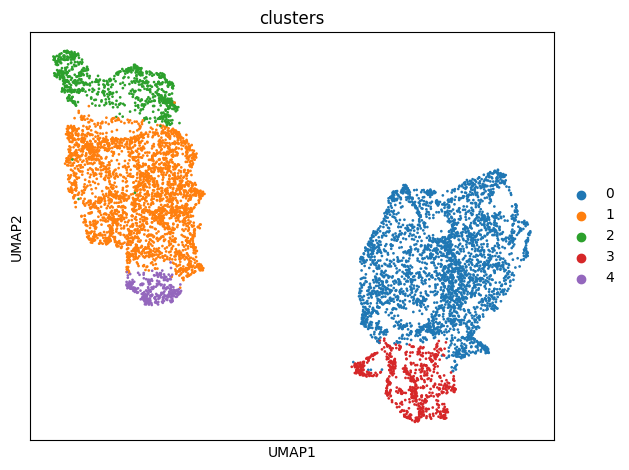

In [8]:
adata, path = clustering(adata, alpha=0, adata_save_path=results_save_path, cluster_resolution=0.2)

plot_all_results(adata, path, figsize, plot_x, plot_y)
# sc.pl.umap(adata,color='clusters', show=True)


result anasys

In [9]:
adata_sc = sc.read_h5ad(f'/mnt/Data16Tc/home/haichao/code/SpaCon/Data/N_20231213_zxw/{mus}/adata_processed.h5ad')
# add allen region
allen_region = pd.read_csv(f'/mnt/Data16Tc/home/haichao/code/SpaCon/Data/N_20231213_zxw/{mus}/allen_region.csv')
adata_sc.obs['region'] = allen_region['region'].to_list()
# add cell type
meta = pd.read_csv(f'/mnt/Data16Tc/home/haichao/code/SpaCon/Data/N_20231213_zxw/{mus}/cell_metadata_with_cluster_annotation.csv')
meta = meta.set_index('cell_label')
meta = meta.loc[adata_sc.obs.index.to_list()]
adata_sc.obs['cell_type'] = meta['class'].to_list()
sc.pp.normalize_total(adata_sc, target_sum=1e4)
sc.pp.log1p(adata_sc)
adata_sc.obs['cell_type_subclass'] = meta['subclass'].to_list()
adata_sc.obs['cell_type_supertype'] = meta['supertype'].to_list()
adata_sc.obs

,brain_section_label,x,y,z,x_ccf,y_ccf,z_ccf,region,cell_type,cell_type_subclass,cell_type_supertype
cell_label,,,,,,,,,,,
198904341065180396762707397604803217407,Zhuang-ABCA-3.023,49.206853,44.877634,12.168155,4.920685,4.487763,1.216815,SSs1,33 Vascular,333 Endo NN,1193 Endo NN_1
252199681526991424029643077826220097990,Zhuang-ABCA-3.023,48.973992,44.813761,12.179006,4.897399,4.481376,1.217901,SSs1,33 Vascular,333 Endo NN,1193 Endo NN_1
277720971126854564514249564750701518375,Zhuang-ABCA-3.023,48.791066,44.577722,12.192707,4.879107,4.457772,1.219271,SSs1,33 Vascular,330 VLMC NN,1188 VLMC NN_2
31551867344111790264292067056219852271,Zhuang-ABCA-3.023,48.830489,44.426120,12.195078,4.883049,4.442612,1.219508,SSs1,33 Vascular,329 ABC NN,1186 ABC NN_1
131102494428104399865219008178262036485,Zhuang-ABCA-3.023,48.308843,43.028156,12.267879,4.830884,4.302816,1.226788,SSs1,34 Immune,334 Microglia NN,1194 Microglia NN_1
...,...,...,...,...,...,...,...,...,...,...,...
318102106429791409781741726367984532777,Zhuang-ABCA-3.009,131.090716,69.334275,41.436743,13.109072,6.933427,4.143674,MDRNd,30 Astro-Epen,318 Astro-NT NN,1160 Astro-NT NN_2
35262847161560382172299767067854387528,Zhuang-ABCA-3.009,131.216032,69.494070,41.351034,13.121603,6.949407,4.135103,MDRNd,33 Vascular,333 Endo NN,1193 Endo NN_1
75415866509570969932943497000463821106,Zhuang-ABCA-3.009,131.415152,70.764504,40.800403,13.141515,7.076450,4.080040,sctd,24 MY Glut,257 SPVC Ccdc172 Glut,1020 SPVC Ccdc172 Glut_1


In [10]:
def add_clusters(adata_clu, clu_obs, cluster_name):
    adata_sc.obs[cluster_name] = 'none'
    for c in range(len(adata_clu.obs[clu_obs].unique())):
        adata_clu_cluster = adata_clu[adata_clu.obs[clu_obs] == f'{c}']

        merge_cellid = adata_clu_cluster.obs['Cells_id'].str.split('_')
        cellid_list = sum(merge_cellid.tolist(), [])
        
        adata_sc.obs.loc[adata_sc.obs.index.isin(cellid_list), cluster_name] = f'{cluster_name}_{c}'


add_clusters(adata, clu_obs='clusters', cluster_name='spacon')

In [11]:
sec = 'Zhuang-ABCA-3.009'
adata_back = adata_sc[adata_sc.obs['brain_section_label'] == sec]
adata_ct = adata_back[adata_back.obs['cell_type_supertype'].isin(['0114 L6 CT CTX Glut_1', '0115 L6 CT CTX Glut_2', '0118 L6 CT CTX Glut_5'])]
# adata_ct.obs

adata_back_ctx = adata_back[adata_back.obs['region'].str.startswith(tuple(ctx_regions))]
# adata_back_ctx.obs

(55.0, 0.0)

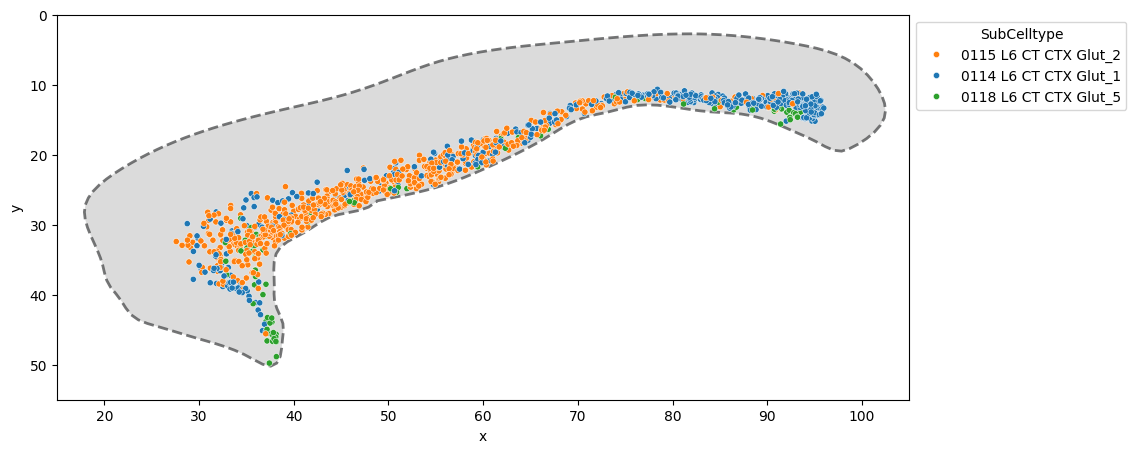

In [12]:
fig = plt.figure(figsize=(11, 5))
sns.scatterplot(data=adata_ct.obs, x='x', y='y', hue='cell_type_supertype', palette=['#ff7f0e', '#1f77b4', '#2ca02c'], legend=True,s=20,zorder=3)
plt.legend(title='SubCelltype', loc='upper left', bbox_to_anchor=(1, 1))
plt.gca().invert_yaxis()
ctx_mask = np.concatenate([adata_back_ctx.obs[['x', 'y']],adata_ct.obs[['x', 'y']]])
concave_hull = alphashape.alphashape(ctx_mask, alpha=0.3)  # Adjust alpha value
buffered_hull = concave_hull.buffer(
    distance=0.5,        # Expansion distance, adjust according to data scale
    resolution=64,       # Buffer precision (higher for smoother)
    join_style=2         # Join style: 1-miter 2-round 3-bevel
)
boundary_concave = np.array(buffered_hull.exterior.coords.xy).T

# Generate smooth curve from original boundary points
tck, u = splprep(boundary_concave.T, s=3.0)  # s is smoothing factor, larger for smoother
u_new = np.linspace(0, 1, 200)       # Increase number of interpolation points
x_new, y_new = splev(u_new, tck)
# Update boundary coordinates
boundary_smoothed = np.column_stack((x_new, y_new))

edge_color = to_rgba('#535455', alpha=1)  
poly = Polygon(
    boundary_smoothed,  # Use concave hull coordinates
    closed=True,
    facecolor='#d3d3d3',
    alpha=0.8,
    edgecolor=edge_color,
    linewidth=2,  
    linestyle='--',
    zorder=2
)
plt.gca().add_patch(poly)
plt.xlim(15, 105)  # Set x-axis range
plt.ylim(55, 0)

Text(0.5, 1.0, 'SpaCon')

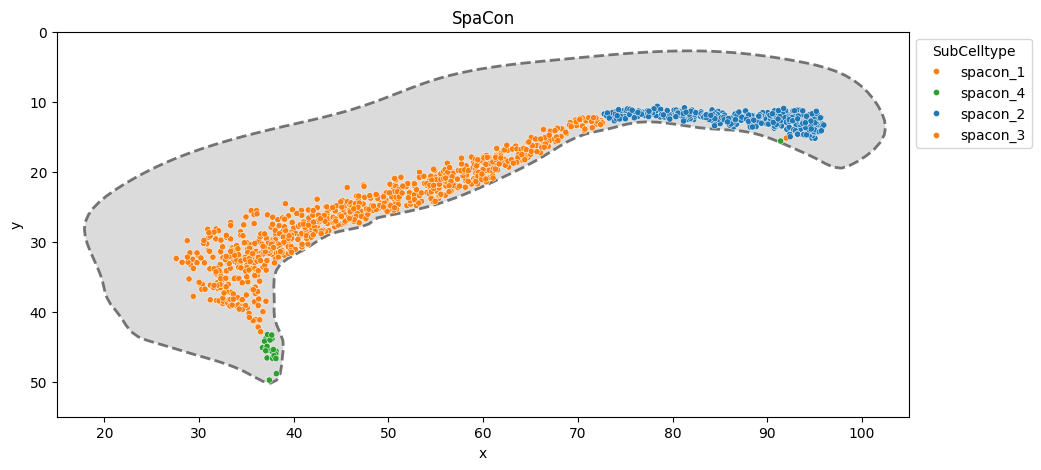

In [13]:
fig = plt.figure(figsize=(11, 5))
sns.scatterplot(data=adata_ct.obs, x='x', y='y', hue='spacon', palette=['#ff7f0e', '#2ca02c', '#1f77b4'], legend=True,s=20, zorder=3)
plt.legend(title='SubCelltype', loc='upper left', bbox_to_anchor=(1, 1))
plt.gca().invert_yaxis()
edge_color = to_rgba('#535455', alpha=1)  
poly = Polygon(
    boundary_smoothed, 
    closed=True,
    facecolor='#d3d3d3',
    alpha=0.8,
    edgecolor=edge_color,
    linewidth=2,  
    linestyle='--',
    zorder=2
)
plt.gca().add_patch(poly)
plt.xlim(15, 105) 
plt.ylim(55, 0)
plt.title('SpaCon')

In [14]:
ari_list = []
nmi_list = []
v_list = []
f1_list = []
methods = ['spacon']
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, homogeneity_completeness_v_measure, confusion_matrix
from scipy.optimize import linear_sum_assignment
def hungarian_f1(true_labels, cluster_labels):
    cm = confusion_matrix(true_labels, cluster_labels)
    row_ind, col_ind = linear_sum_assignment(-cm)
    matched_cm = cm[row_ind[:, np.newaxis], col_ind]
    tp = np.diag(matched_cm)
    fp = matched_cm.sum(axis=0) - tp
    fn = matched_cm.sum(axis=1) - tp
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    return np.nanmean(f1) 

for i in methods:
    true_labels = adata_ct.obs['cell_type_supertype']
    cluster = adata_ct.obs[i]
    _, _, v = homogeneity_completeness_v_measure(true_labels, cluster)
    v_list.append(v)
    ari_list.append(adjusted_rand_score(true_labels, cluster))
    nmi_list.append(normalized_mutual_info_score(true_labels, cluster))
    f1_list.append(hungarian_f1(true_labels, cluster))

df = pd.DataFrame({
    'Method': methods,
    'ARI': ari_list,
    'NMI': nmi_list,
    'V-measure': v_list,
    'F1': f1_list
})

df_long = df.melt(id_vars='Method', var_name='Metric', value_name='Score')
metrics = ['ARI', 'NMI', 'V-measure', 'F1']
df_long

,Method,Metric,Score
0,spacon,ARI,0.300474
1,spacon,NMI,0.239463
2,spacon,V-measure,0.239463
3,spacon,F1,0.611847
